In [1]:
# Core 
import datetime
import os
import glob

# Analysis 
import xarray as xr
import numpy as np
import pyproj as pp
import scipy as sp
import transect_analysis as ta

# Plotting 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as mticker
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors

# Debugging 
import pdb
%load_ext line_profiler

In [2]:
# Specify start and end coords on coast.
# Choose order so that (transect_axis, coastline_axis) forms a right hand coordinate system
lon0 = 134.5293 
lat0 = -12.4715
coast_lon1 = 133.3290
coast_lat1 = -12.1468

trans_lon0, trans_lat0, trans_lon1, trans_lat1, n_points, n_trans, coast_distances, tran_distances = ta.define_transects(
    lon0, lat0, coast_lon1, coast_lat1, 453300
)

static_path = '/g/data/ua8/ARCCSS_Data/MCASClimate/v1-0/static/static.nc'
static = xr.open_dataset(static_path).sel(latitude=slice(-12.75,-6), longitude=slice(130,139))
static_tran = ta.calc_transects(static, trans_lon0, trans_lat0, trans_lon1, trans_lat1, n_points, n_trans) 
static_tran = static_tran.assign_coords(coastal_axis = coast_distances)
static_tran = static_tran.assign_coords(transect_axis = tran_distances)

# Calcualate distance where landmask drops below 0.5
coast_i = np.where(static_tran.mean('coastal_axis').LANDMASK.values < 0.5)[0][0] - 1
coast_location = tran_distances[coast_i]

# Redefine tran_distances so that coastline occurs at 0.
tran_distances = tran_distances - coast_location

# Create basis vectors of new coordinate system
b_lon = trans_lon1[0] - lon0
b_lat = trans_lat1[0] - lat0

In [22]:
# Define local solar time based on mean of transect lon values
lon_mean = np.mean(np.concatenate((trans_lon0, trans_lon1)))
LST = (test2.hour.values + (lon_mean / 360) * 24) % 24
LST

array([ 8.96441863,  9.96441863, 10.96441863, 11.96441863, 12.96441863,
       13.96441863, 14.96441863, 15.96441863, 16.96441863, 17.96441863,
       18.96441863, 19.96441863, 20.96441863, 21.96441863, 22.96441863,
       23.96441863,  0.96441863,  1.96441863,  2.96441863,  3.96441863,
        4.96441863,  5.96441863,  6.96441863,  7.96441863])

In [58]:
ASCAT = xr.open_dataset('/g/data/w40/esh563/goulburn_NT/transect_means/ASCAT_goulburn_2012-2014_12.nc')
ASCAT = ASCAT.mean('coastal_axis')

WRF = xr.open_dataset('/g/data/w40/esh563/goulburn_NT/transect_means/wind_proj_goulburn_02-2012_12.nc')
WRF = WRF.isel(level = 0)
WRF_0930 = test2.isel(hour = [0,1]).mean('hour')
WRF_2130 = test2.isel(hour = [12, 13]).mean('hour')

In [59]:
sig_point = np.where(np.logical_or(ASCAT.p_value.values < 0.05, np.isnan(ASCAT.p_value.values)))[0][-1]
sig_point

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


15

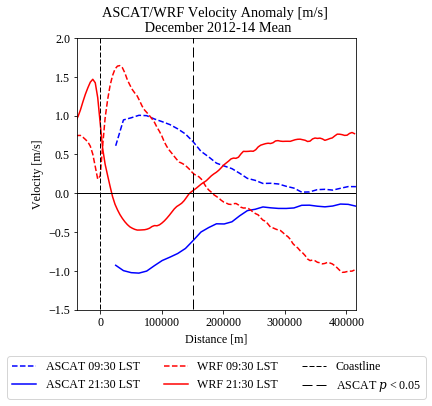

In [80]:
fig, ax = plt.subplots(figsize=[5,5])

# Initialise fonts
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset' : 'dejavuserif'}) 
rcParams.update({'font.size': 12})

plt.plot(ASCAT.transect_axis, ASCAT.wind_proj[0,:], 'b--')
plt.plot(ASCAT.transect_axis, ASCAT.wind_proj[8,:], 'b-')
plt.plot(WRF_0930.transect_axis, WRF_0930.wind_proj, 'r--')
plt.plot(WRF_2130.transect_axis, WRF_2130.wind_proj, 'r-')

plt.plot(
    [0, 0], [-4, 3], '--',
    dashes = (5, 2), color='black', linewidth = 1
)

plt.plot(
    [ASCAT.transect_axis[sig_point], ASCAT.transect_axis[sig_point]],  [-4, 3,], '--',
    dashes = (10, 4), color='black', linewidth = 1
)

plt.plot(
    [ASCAT.transect_axis[0], ASCAT.transect_axis[-1]], [0,0], '-',
    color='black', linewidth = 1
)

plt.xlim((ASCAT.transect_axis[0], ASCAT.transect_axis[-1]))
plt.ylim((-1.5,2))


plt.legend(
    ['ASCAT 09:30 LST', 'ASCAT 21:30 LST', 'WRF 09:30 LST', 'WRF 21:30 LST', 'Coastline', 'ASCAT $p$ < 0.05'],
    ncol = 3, loc = 'lower center', bbox_to_anchor=(0.5, -0.35)
)

plt.title(
    'ASCAT/WRF Velocity Anomaly [m/s] \n December 2012-14 Mean'
)
plt.xlabel('Distance [m]')
plt.ylabel('Velocity [m/s]')

file_name = '/g/data/w40/esh563/goulburn_NT/ASCAT_WRF_2012-2014_12_plot.png'
plt.savefig(file_name, bbox_inches='tight')